In [2]:
# install package

!pip install radiomics
!pip install pyradiomics
!pip install SimpleITK
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for radiomics: filename=radiomics-0.1-py3-none-any.whl size=6091 sha256=c4b313cd9648d844a28a20cda1233f3a72bb991a928037b074137943d063d2fc
  Stored in directory: /root/.cache/pip/wheels/72/f5/9b/32efc9afd085f158d92202cb88e07ddd5793ea549381868b29
Successfully built radiomics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 34.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics fro

In [3]:

import os
import pandas as pd

import imageio
import nibabel as nib
import scipy.ndimage as ndi
import cv2
import SimpleITK as sitk
from skimage import io
from skimage.measure import find_contours

import math
import numpy as np
import cv2
import SimpleITK as sitk
from skimage import io
from skimage.measure import find_contours

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt


def biggest_tumor(images, masks):
  '''
  return images/masks index correspond to the biggest tumor
  masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
  images and masks are 3D array with same dimension
  masks should contain at leat one slice with tumor
  '''
  mask_size = {}

  for idx in range(0, masks.shape[2]):
    if has_tumor(masks[:,:,idx]):
      mask_size[idx+1] = sum(masks[:,:,idx].ravel())
  return max(mask_size, key=mask_size.get)


def get_bounding_box(mask, crop_margin=0):
    """
    Return the bounding box of a mask image.
    slightly modify from https://github.com/guillaumefrd/brain-tumor-mri-dataset/blob/master/data_visualization.ipynb
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row + crop_margin
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row + crop_margin
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col + crop_margin
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col + crop_margin
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=0):
    """
    Crop an image to the bounding by forcing a squared image as output.
    from https://github.com/guillaumefrd/brain-tumor-mri-dataset/blob/master/data_visualization.ipynb
    """
    x1, y1, x2, y2 =  bbox

    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])

    return image[y1:y2, x1:x2]


def has_tumor(mask):
    '''
    mask should be a binary 2D array (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    Return True if any pixel values of mask are equal to 1
    '''
    return sum(mask.ravel()) > 0

def get_index_tumor_slice(masks):
  '''
    Return index of images/masks where tumor is visible
    Masks are 2D or 3D array with same dimensions
    Masks should contain at least one slice with tumor
  '''
  tumor_idx = []
  if len(masks.shape) == 3:
    for i in range(0, masks.shape[2]):
      # detect binary mask with no tumor (all pixel equal to 0)
      if has_tumor(masks[:,:,i]):
        tumor_idx.append(i)
  elif len(masks.shape) == 2:
      # detect binary mask with no tumor (all pixel equal to 0)
    if has_tumor(masks[:,:,i]):
      tumor_idx.append(i)

  if not tumor_idx:
    raise ValueError("There must be at least one slice with tumor")
  else:
    return tumor_idx



def image_picker(min_slice, max_slice):
    '''
    return an array containing (max 18) equidistant index number between min_slice and max_slice
    min_slice and max_slice are interger (min_slice cannot be >= max_slice)
    '''
    row = 3
    col = 6
    picker = math.ceil((max_slice - min_slice)/(row*col))
    index_list = []
    index = min_slice

    for i in range(row*col):
      if index < max_slice:
        index_list.append(index)
        index += picker
      else:
        index_list.append(max_slice)
        break
    return index_list



def plot_bbox_image(images, masks, crop_margin=0, zooming=False):
  '''
    Plot equidistant slices with bounding boxe containing the tumor
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D array with same dimensions
  '''

  if len(masks.shape) != 2:
    raise ValueError("only accept one array of 2D dimension")

  xmin, ymin, xmax, ymax = get_bounding_box(masks, crop_margin)

  plt.imshow(images, cmap='gray')
  plt.plot([xmin, xmax], [ymin, ymin], color='red')
  plt.plot([xmax, xmax], [ymin, ymax], color='red')
  plt.plot([xmin, xmin], [ymin, ymax], color='red')
  plt.plot([xmin, xmax], [ymax, ymax], color='red')

  if zooming:
    plt.plot([xmax, 511], [ymax, 511], color='red')
    plt.plot([xmax, 511], [ymin, 0], color='red')



def PlotImage(images, masks=None, show_tumor_only = False, dislay_mode=None):
  '''
    Plot equidistant slices along mask and corresponding images along col/row grid
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D or 3D array with same dimensions
    if masks = None, Only images are displayed
    if show_tumor_only = True: Only images containing tumor and/or corresponding masks are displayed

    if dislay_mode = 'mask' : Display tumor mask with corresponding images
    if dislay_mode = 'frame' : Display bounding box with corresponding images
    if dislay_mode = 'contour' : Display tumor contour with corresponding images
  '''
  row = 3
  col = 6
  images = np.rot90(images, axes=(1, 0))

  if show_tumor_only:
    images_idx = get_index_tumor_slice(masks)
    slices_picker = image_picker(min_slice = images_idx[0], max_slice=images_idx[-1])
  else:
    slices_picker = image_picker(min_slice = 0, max_slice=images.shape[2]-1)

  if masks is not None:
    masks = np.rot90(masks, axes=(1, 0))

  plt.figure(figsize=(16, 8))
  for i, idx in enumerate(slices_picker):
    plt.subplot(row, col, i+1)
    plt.imshow(images[:,:,idx], cmap='gray')

    if masks is not None:
      if dislay_mode == 'mask':
        tumor = np.ma.masked_where(masks[:,:,idx] == False, masks[:,:,idx])
        plt.imshow(tumor, cmap='Set1')

      if dislay_mode == 'frame':
        plot_bbox_image(images[:,:,idx], masks[:,:,idx], crop_margin=0, zooming=False)

      if dislay_mode == 'contour':
        contours = find_contours(masks[:,:,idx],0)
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
    plt.title(str(idx+1))
    plt.axis('off')
  plt.subplots_adjust(wspace=0.05, hspace=0.2)
  plt.show()


def plot_tumor(images, masks, idx, save=False):
  '''
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D or 3D array with same dimension
    masks should contain at leat one slice with tumor
    idx : images index along slice number (must be between min and max of tumor containing images dimension)
    if save = True, save figure in current repository
  '''
  idx -= 1
  image = np.array(images, dtype='uint8')
  mask = np.array(masks, dtype='uint8')

  image = np.rot90(image[:,:,idx], axes=(0, 1))
  mask = np.rot90(mask[:,:,idx], axes=(0, 1))

  fig, ax = plt.subplots(1, 3, figsize=(6, 2))

  # show image
  ax[0].imshow(image, cmap='gray')
  xmin, ymin, xmax, ymax = get_bounding_box(mask, crop_margin=10)
  ax[0].plot([xmin, xmax], [ymin, ymin], color='red')
  ax[0].plot([xmax, xmax], [ymin, ymax], color='red')
  ax[0].plot([xmin, xmin], [ymin, ymax], color='red')
  ax[0].plot([xmin, xmax], [ymax, ymax], color='red')
  ax[0].plot([xmax, 511], [ymax, 511], color='red')
  ax[0].plot([xmax, 511], [ymin, 0], color='red')

  # show image cropped around the tumor
  bbox = get_bounding_box(mask)
  croped_image = crop_to_bbox(image, bbox, crop_margin=10)
  croped_image = cv2.resize(croped_image, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  croped_masks = crop_to_bbox(mask, bbox, crop_margin=10)
  croped_masks = cv2.resize(croped_masks, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  ax[1].imshow(croped_image, cmap='gray')

  # show only the tumor
  croped_masks = crop_to_bbox(mask, bbox, crop_margin=10)
  croped_masks = cv2.resize(croped_masks, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  croped_tumor = np.ma.masked_where(croped_masks == False, croped_image)
  croped_tumor_background = np.ma.masked_where(croped_masks == True, np.zeros((512, 512)))
  ax[2].imshow(croped_tumor, cmap='gray')
  ax[2].imshow(croped_tumor_background, cmap='gray')

  # lighten ticks and labels
  for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_color('red')
    ax[2].spines[axis].set_color('red')

    ax[1].spines[axis].set_linewidth(1)
    ax[2].spines[axis].set_linewidth(1)

    ax[1].axes.get_yaxis().set_visible(False)
    ax[1].axes.get_xaxis().set_visible(False)
    ax[2].axes.get_yaxis().set_visible(False)
    ax[2].axes.get_xaxis().set_visible(False)  
    
  plt.subplots_adjust(wspace=0.02)
  fig.suptitle("Slice {}/{}".format(idx,images.shape[2]-1), fontsize=14, y = 1.05)
  plt.show()

  if True:
    fig.savefig('comparison.pdf', dpi=200) 


In [4]:
# import librairy

import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
from radiomics import featureextractor
# from utility import biggest_tumor, PlotImage, PlotImage

In [5]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_url = '/content/drive/MyDrive/Data_npy_format/'

labels = np.load(base_url + 'labels.npy')
images = np.load(base_url + 'images.npy')
masks = np.load(base_url + 'masks.npy')
patient_ids = np.load(base_url + 'patient_ids.npy')

In [7]:
print(labels.shape)
print(images.shape)
print(masks.shape)
print(patient_ids.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)
(3064, 1, 1)


In [8]:
unique, counts = np.unique(patient_ids, return_counts=True)
print(len(unique))

233


In [9]:
patients_slices = {} 

# gather all slices coording to patient in a dicto called patients_slices (key: patient name, value: array containing slices id)
for patient in patient_ids:
  patient = patient[0][0]
  patients_slices[patient] = np.asarray(np.where(patient_ids == patient))[0]

# check if all slices id from patients_slices are correct in patients_slices
for patient, slice_id in patients_slices.items():
  #for id in slice_id:
  if all(patient_ids != patient):
    print(f"error for {patient}: slice {id}")


In [10]:
# visualize first patient 98772
print(list(patients_slices.items())[0])

('98472', array([   0,   49,  134,  241,  250,  295,  345,  539,  570,  876,  897,
       1473, 1955, 2467, 2561, 2593, 2729, 2799]))


In [11]:
data_spacing = [1,1,1]

images_radiomic = []
masks_radiomic = []
patients = []

for patient in patients_slices:
  
  # images
  img = images[patients_slices[patient]]
  sitk_img = sitk.GetImageFromArray(img)
  sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2])))
  images_radiomic.append(sitk_img)

  # mask
  mask_slice = masks[patients_slices[patient]].astype(int)
  sitk_mask = sitk.GetImageFromArray(mask_slice)
  sitk_mask.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2])))
  masks_radiomic.append(sitk_mask)

  # patient
  patients.append(patient)
  # label

In [12]:
nbslice = []
patients_name = []

for (img, mask) in zip(images_radiomic, masks_radiomic):

    # convert sitk to numpy array
    image_3d = sitk.GetArrayFromImage(img)
    mask_3d = sitk.GetArrayFromImage(mask)

    # check if size mask and image are equal
    if image_3d.shape[0] != mask_3d.shape[0] or image_3d.shape[1] != mask_3d.shape[1]:
        print("size different between mask and image")
       # check if same number of slice in mask and image
    elif image_3d.shape[2] != image_3d.shape[2]:
        print("slice number different between mask and image")
    else:
        # gather number of images by patient
        slice_image = image_3d.shape[0] 
        nbslice.append(slice_image)
        patients_name.append(patient)

patients_slice_df = pd.DataFrame({'patients': pd.Series(patients), 'nbrslide': pd.Series(nbslice)})


In [13]:
patients_slice_df

,patients,nbrslide
0,98472,18
1,MR048994B,17
2,112074,14
3,90284,19
4,MR029209I,26
...,...,...
228,53669,1
229,95969,1
230,111696,1
231,88510,1


In [14]:
print(patients_slice_df.head())
print('\n')
print('Min slice : {}'.format(patients_slice_df['nbrslide'].min()))
print('Max slice : {}'.format(patients_slice_df['nbrslide'].max()))
print('Mean slice : {:.0f}'.format(patients_slice_df['nbrslide'].mean()))

    patients  nbrslide
0      98472        18
1  MR048994B        17
2     112074        14
3      90284        19
4  MR029209I        26


Min slice : 1
Max slice : 38
Mean slice : 13


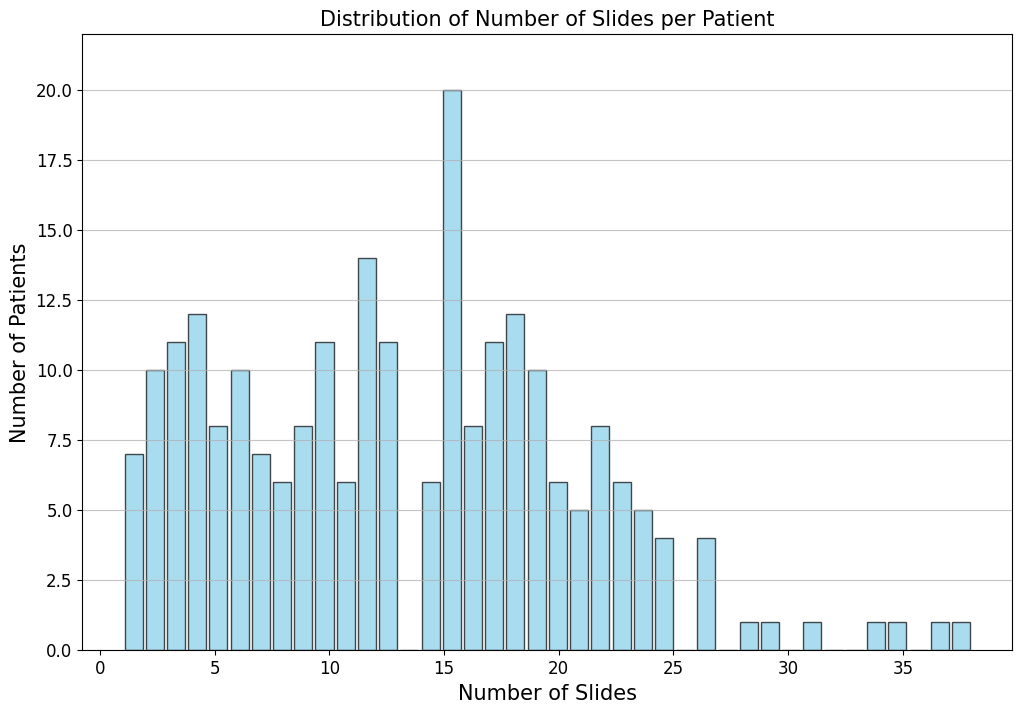

In [15]:
plt.figure(figsize=(12,8))
plt.grid(axis='y', alpha=0.75)
plt.hist(patients_slice_df['nbrslide'], bins=40, edgecolor='black', color='skyblue', alpha=0.7, rwidth=0.85)
plt.xlabel('Number of Slides', fontsize=15)
plt.ylabel('Number of Patients', fontsize=15)
plt.title('Distribution of Number of Slides per Patient', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

maxfreq = np.max(np.histogram(patients_slice_df['nbrslide'], bins=40)[0])
plt.ylim(0, maxfreq + 0.1*maxfreq)

plt.show()

In [16]:
patient_ids_clean = [item[0][0] for item in patient_ids]
patient_label_dict = dict(zip(patient_ids_clean, labels))
patients_slice_df['label'] = patients_slice_df['patients'].map(patient_label_dict)


In [17]:
patients_slice_df

,patients,nbrslide,label
0,98472,18,3
1,MR048994B,17,2
2,112074,14,3
3,90284,19,2
4,MR029209I,26,2
...,...,...,...
228,53669,1,1
229,95969,1,1
230,111696,1,1
231,88510,1,1


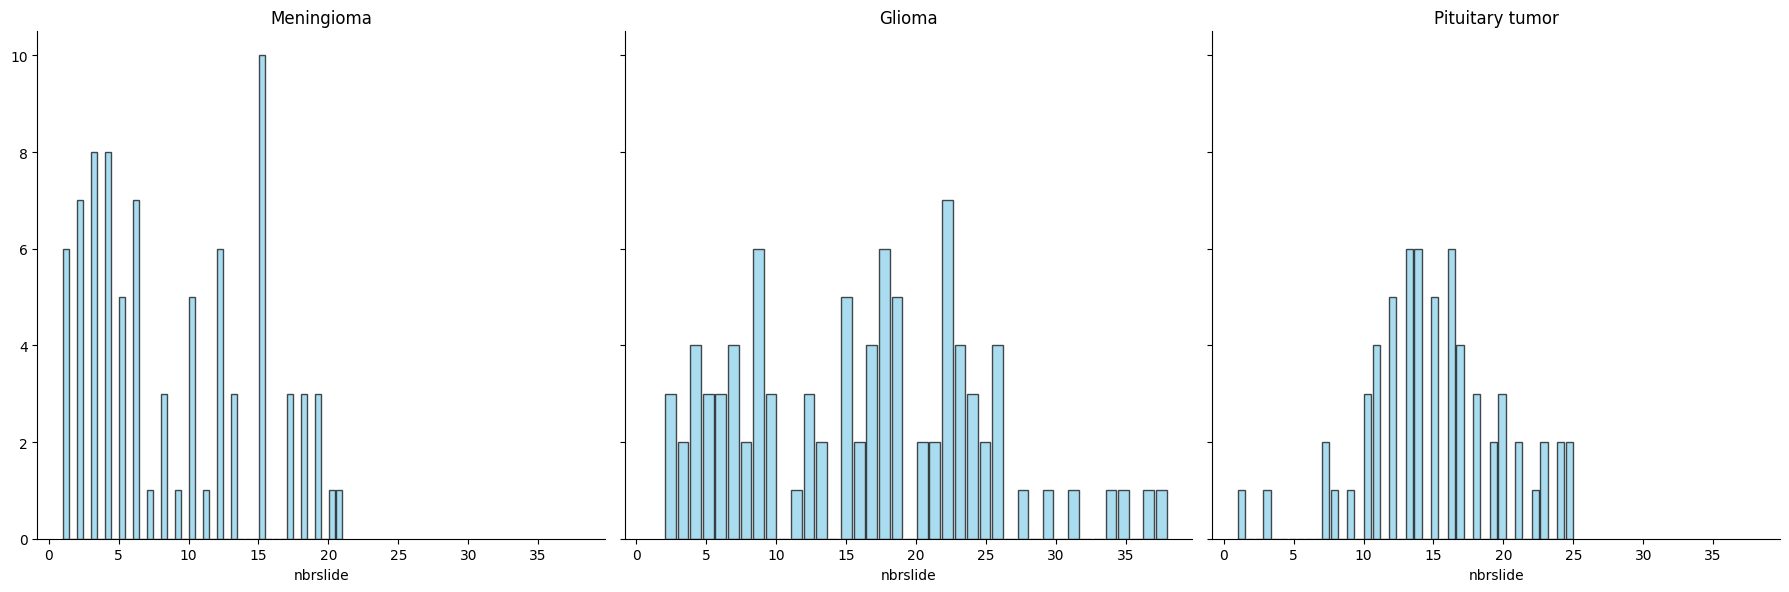

In [22]:
import seaborn as sns

tumors_type = {'1': 'Meningioma', '2': 'Glioma', '3': 'Pituitary tumor'}

g = sns.FacetGrid(patients_slice_df, col='label', height=6, aspect=1)
g = g.map(plt.hist, "nbrslide", bins=40, color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.85)

# Set titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_title(tumors_type[ax.get_title().split('=')[1].strip()])

plt.show()


108945
2
[  33  249  643  972 1252 1336 1513 1932 2238 2302 2575 2738]
(512, 512, 12)


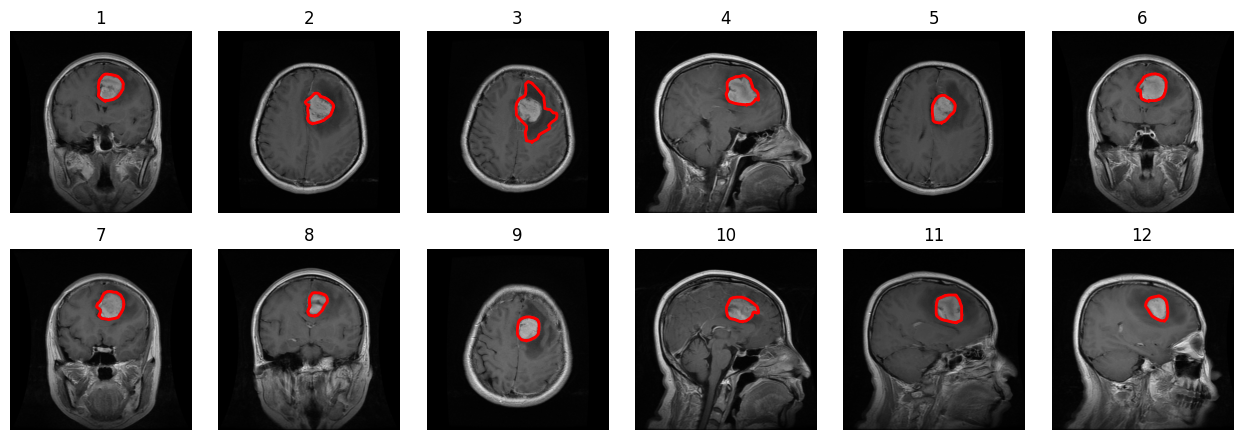

In [27]:
# Visalize one patient 

id = 30
print(patients[id])
print(labels[id])
print(patients_slices[patients[id]])

image_radiomic = sitk.GetArrayFromImage(images_radiomic[id])
mask_radiomic = sitk.GetArrayFromImage(masks_radiomic[id])
image_radiomic = np.transpose(image_radiomic)
mask_radiomic = np.transpose(mask_radiomic)

print(image_radiomic.shape)


PlotImage(image_radiomic, masks=mask_radiomic, show_tumor_only = True, dislay_mode='contour')

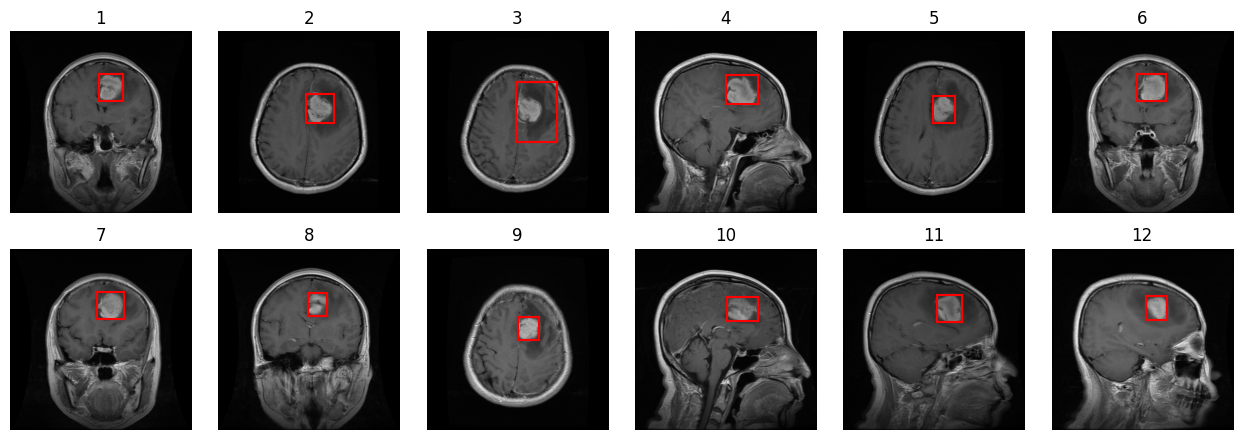

In [28]:
PlotImage(image_radiomic, masks=mask_radiomic, show_tumor_only = True, dislay_mode='frame')

In [29]:
index_biggest_tumor = biggest_tumor(image_radiomic, mask_radiomic)
print(index_biggest_tumor)

3


2


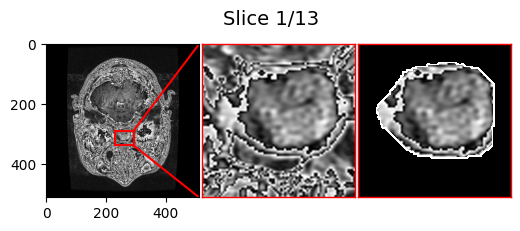

In [30]:
# get index slice with the biggest tumor size
#index_biggest_tumor = biggest_tumor(image_3d, mask_3d)

index_biggest_tumor = 2

image_radiomic = sitk.GetArrayFromImage(images_radiomic[index_biggest_tumor])
mask_radiomic = sitk.GetArrayFromImage(masks_radiomic[index_biggest_tumor])

image_radiomic = np.transpose(image_radiomic)
mask_radiomic = np.transpose(mask_radiomic)

print(index_biggest_tumor)

plot_tumor(image_radiomic, mask_radiomic, index_biggest_tumor)

In [31]:
# Define settings for signature calculation
# These are currently set equal to the respective default values
settings = {}

# https://www.nature.com/articles/s41598-020-69298-z
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213459

# Normalizes the image by centering it at the mean with standard deviation. Normalization is based on all gray values in the image, not just those inside the segmentation.
settings['normalize'] = True
settings['binWidth'] = 32
settings['resampledPixelSpacing'] = None  # [3,3,3] is an example for defining resampling (voxels with size 3x3x3mm)
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'normalize': True, 'binWidth': 32, 'resampledPixelSpacing': None}


In [32]:
data_spacing = [1,1,1]
featureVector_list = []

for (img, mask,label, patient) in zip(images, masks, labels, patient_ids):

  # convert to numpy array
  img_slide = sitk.GetImageFromArray(img)
  mask_slide = sitk.GetImageFromArray(mask.astype(int))
  
  # radiomic extraction
  order_dict = extractor.execute(img_slide, mask_slide)
  order_dict['patient'] = patient
  order_dict['disease'] = label
  featureVector_list.append(order_dict)


Streaming output truncated to the last 5000 lines.
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Lo

In [33]:
import pandas as pd

radiomics = pd.DataFrame()

for featureVector in featureVector_list:
  new_df = pd.DataFrame.from_dict(data=featureVector, orient='index')
  radiomics = radiomics.append(new_df.T)


Streaming output truncated to the last 5000 lines.
<ipython-input-33-e2a0098c6136>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  radiomics = radiomics.append(new_df.T)
<ipython-input-33-e2a0098c6136>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  radiomics = radiomics.append(new_df.T)
<ipython-input-33-e2a0098c6136>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  radiomics = radiomics.append(new_df.T)
<ipython-input-33-e2a0098c6136>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  radiomics = radiomics.append(new_df.T)
<ipython-input-33-e2a0098c6136>:7: FutureWarning: The frame.append method is deprecated and will be removed from 

In [34]:
radiomics

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,patient,disease
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},68dd5efd97e6d0191ee8a4cf0a2c6bedac14d662,2D,"(1.0, 1.0)",...,-3.203426503814917e-16,0.0004716981132075472,0.0,0.0,1000000.0,0.0,0.0,0.0,[[98472]],3
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},4bd5152c9b6bfc7ddad51e71a0ea09d22d911db2,2D,"(1.0, 1.0)",...,3.235926350629029,0.003778677462887989,439059.37244897964,49.51287611000948,0.007526556031661859,0.07172085929554499,0.012265488009504378,0.007538229592935603,[[MR048994B]],2
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},0185e1d7d948ab8625a9cf75381018018120a7c3,2D,"(1.0, 1.0)",...,3.1219280948873593,0.004004805766920304,531123.4100000001,6.216520424424184,0.041745130680123546,0.019186936064987073,0.00048696076713263166,0.039200130667102234,[[112074]],3
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},78a5ea7cd987a52f831366d92b9c0987c3d5fbe0,2D,"(1.0, 1.0)",...,-3.203426503814917e-16,0.0007230657989877079,0.0,0.0,1000000.0,0.0,0.0,0.0,[[90284]],2
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},a795db87f6df719293273c92025417f9e7636725,2D,"(1.0, 1.0)",...,2.5216406363433164,0.0007932910244786945,9483888.244897958,3.7584264704289714,0.06674411650526561,0.0033958735284870052,7.596240527493902e-06,0.06747529922082095,[[MR029209I]],2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},37ca7a6c550293e580122cc6f2af4158dd32880a,2D,"(1.0, 1.0)",...,3.0220552088741974,0.0010621348911311736,9539203.25,14.408056882051017,0.017615684952186027,0.010049139862326383,0.00010326357805233078,0.016974326331423723,[[MR017260F]],2
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},45c80b1b4e7e289ec2e9a63ea7e554aae806c1ae,2D,"(1.0, 1.0)",...,2.807354922057602,0.004383218534752661,284701.55102040817,7.104272535144377,0.03736607446892518,0.03351564676209077,0.0012435746160767496,0.037578848476714534,[[MR054875]],2
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},86977314bdf44d9331e294a52a8f628edc27c932,2D,"(1.0, 1.0)",...,1.5849625007211552,0.0008147745790331341,3005334.888888889,0.6326638017545562,0.39563811561498285,0.0013729290259216515,1.1668583417553187e-06,0.3789758628468306,[[103148]],2
0,v3.0.1,1.22.4,2.2.1,1.4.1,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},90622bae41a2ac51b98cb8bae55ba4506c2ca79c,2D,"(1.0, 1.0)",...,-3.203426503814917e-16,0.0029069767441860465,0.0,0.0,1000000.0,0.0,0.0,0.0,[[MR053110B]],2


In [35]:
radiomics.to_csv("radiomic_variable.csv", index=False)

In [36]:
radiomics_data = radiomics.iloc[:,22:]
radiomics_data.index = radiomics_data['patient']
radiomics_data.index.name = None
radiomics_data.to_csv("radiomic.csv", index=False)

radiomics_data

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,patient,disease
[[98472]],1.1886964185263778,2.37298414659487,8460.498535265771,-3.203426503814917e-16,0.47532636704789843,4.466516753280361,3.597553770175896,0.37120389800723674,1.93029751544859,2.0265598451870797,...,-3.203426503814917e-16,0.0004716981132075472,0.0,0.0,1000000.0,0.0,0.0,0.0,[[98472]],3
[[MR048994B]],-0.19849406700537914,0.8915358741937537,1533.4035842494166,0.7591311885509202,0.5207398785182641,14.456128900648286,4.923941895892703,0.3740420332187088,0.32729559286809384,0.26077501382313495,...,3.235926350629029,0.003778677462887989,439059.37244897964,49.51287611000948,0.007526556031661859,0.07172085929554499,0.012265488009504378,0.007538229592935603,[[MR048994B]],2
[[112074]],0.48927721007338354,2.2052819705812032,6470.934678766987,0.16563492226334908,0.8864481029608628,2.8924999881628866,2.926347964780711,0.5155655105560787,1.4757249926639513,1.6032910946898709,...,3.1219280948873593,0.004004805766920304,531123.4100000001,6.216520424424184,0.041745130680123546,0.019186936064987073,0.00048696076713263166,0.039200130667102234,[[112074]],3
[[90284]],0.8394214812189491,2.518100305004647,4531.267991253087,-3.203426503814917e-16,0.8939647553451993,2.339228873785699,3.1252820072250054,0.5026741916297557,1.7026760015521627,1.7239318501973957,...,-3.203426503814917e-16,0.0007230657989877079,0.0,0.0,1000000.0,0.0,0.0,0.0,[[90284]],2
[[MR029209I]],0.3848134689456759,1.523653623485714,9352.132333745889,0.023178485534376295,0.5833731946827033,4.357846122368237,3.265799997583719,0.3556962928797023,0.926406977227128,0.8685215392520632,...,2.5216406363433164,0.0007932910244786945,9483888.244897958,3.7584264704289714,0.06674411650526561,0.0033958735284870052,7.596240527493902e-06,0.06747529922082095,[[MR029209I]],2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[[MR017260F]],0.27697763349446614,1.6364464282906979,15188.938601602315,0.08080487111921202,0.5519210919044529,3.318224539873707,3.3319092913164825,0.39092906913032016,1.0372454108775284,1.052572010012829,...,3.0220552088741974,0.0010621348911311736,9539203.25,14.408056882051017,0.017615684952186027,0.010049139862326383,0.00010326357805233078,0.016974326331423723,[[MR017260F]],2
[[MR054875]],0.20521402177233278,2.5658324904823484,3655.4074854032883,0.2368684568105351,1.3302892088734242,2.5466883662064808,3.676740671927523,0.7275176214770627,1.2284338473017198,1.1046025339949745,...,2.807354922057602,0.004383218534752661,284701.55102040817,7.104272535144377,0.03736607446892518,0.03351564676209077,0.0012435746160767496,0.037578848476714534,[[MR054875]],2
[[103148]],0.5217869585880833,1.7417574113490177,4772.227577581362,0.00953564792738092,0.6532639639951455,2.6995101809480837,2.570236102830004,0.3750966104530731,1.0439577456228584,0.9510747063563219,...,1.5849625007211552,0.0008147745790331341,3005334.888888889,0.6326638017545562,0.39563811561498285,0.0013729290259216515,1.1668583417553187e-06,0.3789758628468306,[[103148]],2
[[MR053110B]],0.4389753969632144,0.8241239095808839,149.530644392461,-3.203426503814917e-16,0.15624800526522326,11.597859934990336,1.8217420399493816,0.14912724174411182,0.6143257735882914,0.5514513978653283,...,-3.203426503814917e-16,0.0029069767441860465,0.0,0.0,1000000.0,0.0,0.0,0.0,[[MR053110B]],2


In [39]:
!ls

comparison.pdf	drive  radiomic.csv  radiomic_variable.csv  sample_data
